In [1]:
import torch
import torch.nn as nn
import gym
from parameters import dotdict, MemoryBufferSimple, SensorModel, DriveDQN, model_params
from agent_torch_trans import DQN_Agent
from parameters.setup import setup_dict_trans
import environment as env_wrapper
from collections import deque
import matplotlib.pyplot as plt    
import random
%load_ext autoreload
%autoreload 2

In [2]:
args = model_params
args.device = 'cpu'

In [3]:
def compute_steering_speed_gyro_abs(a):
    right_steering = a[6, 36:46].mean()/255
    left_steering = a[6, 26:36].mean()/255
    steering = (right_steering - left_steering + 1.0)/2
    
    left_gyro = a[6, 46:60].mean()/255
    right_gyro = a[6, 60:76].mean()/255
    gyro = (right_gyro - left_gyro + 1.0)/2
    
    speed = a[:, 0][:-2].mean()/255
    abs1 = a[:, 6][:-2].mean()/255
    abs2 = a[:, 8][:-2].mean()/255
    abs3 = a[:, 10][:-2].mean()/255
    abs4 = a[:, 12][:-2].mean()/255
    
    return [steering, speed, gyro, abs1, abs2, abs3, abs4]

In [4]:
env = gym.make('CarRacing-v0')
state_img = env.reset()

Track generation: 1134..1429 -> 295-tiles track


c:\Users\test\Documents\driving\rl_ad\env\lib\site-packages\pyglet\image\codecs\wic.py:406: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


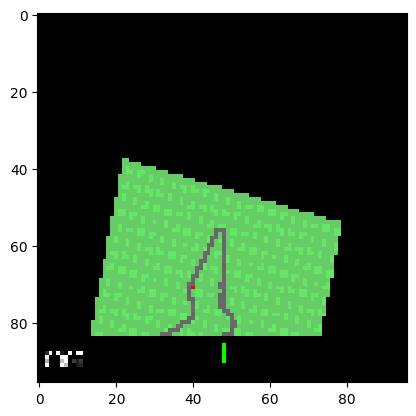

In [5]:
plt.imshow(state_img)

In [6]:
buffer = MemoryBufferSimple(args.n_frames, args.buffer_sz)
sampler = torch.utils.data.DataLoader(buffer, batch_size=32, shuffle=True, drop_last=False)

In [7]:
state_frame_stack = deque(maxlen=args.n_frames)
for i in range(100):
    state_img, reward, done, info = env.step((0.1,1,0))
    state_img = state_img/255.0 
    data_board = state_img[84:, 12:]
    steering, speed, gyro, abs1, abs2, abs3, abs4 = compute_steering_speed_gyro_abs(data_board)
    action_idx = random.randint(0, args.act_dim-1)
    state = {'img': state_img,
             'steering': steering,
             'speed': speed,
             'gyro': gyro,
             'abs1': abs1,
             'abs2': abs2,
             'abs3': abs3,
             'abs4': abs4,
             'action_idx': action_idx}
    state_frame_stack.append(state)
    buffer.add_experience(state, action_idx, reward, done)

state_img.shape, reward, done, info

((96, 96, 3), -0.09999999999999964, False, {})

In [8]:
sensor_net = SensorModel(args.in_channels, args.h_size,
                         p=args.c_dropout, image_shape=args.img_shape)
states, actions, rewards, dones = next(iter(sampler))

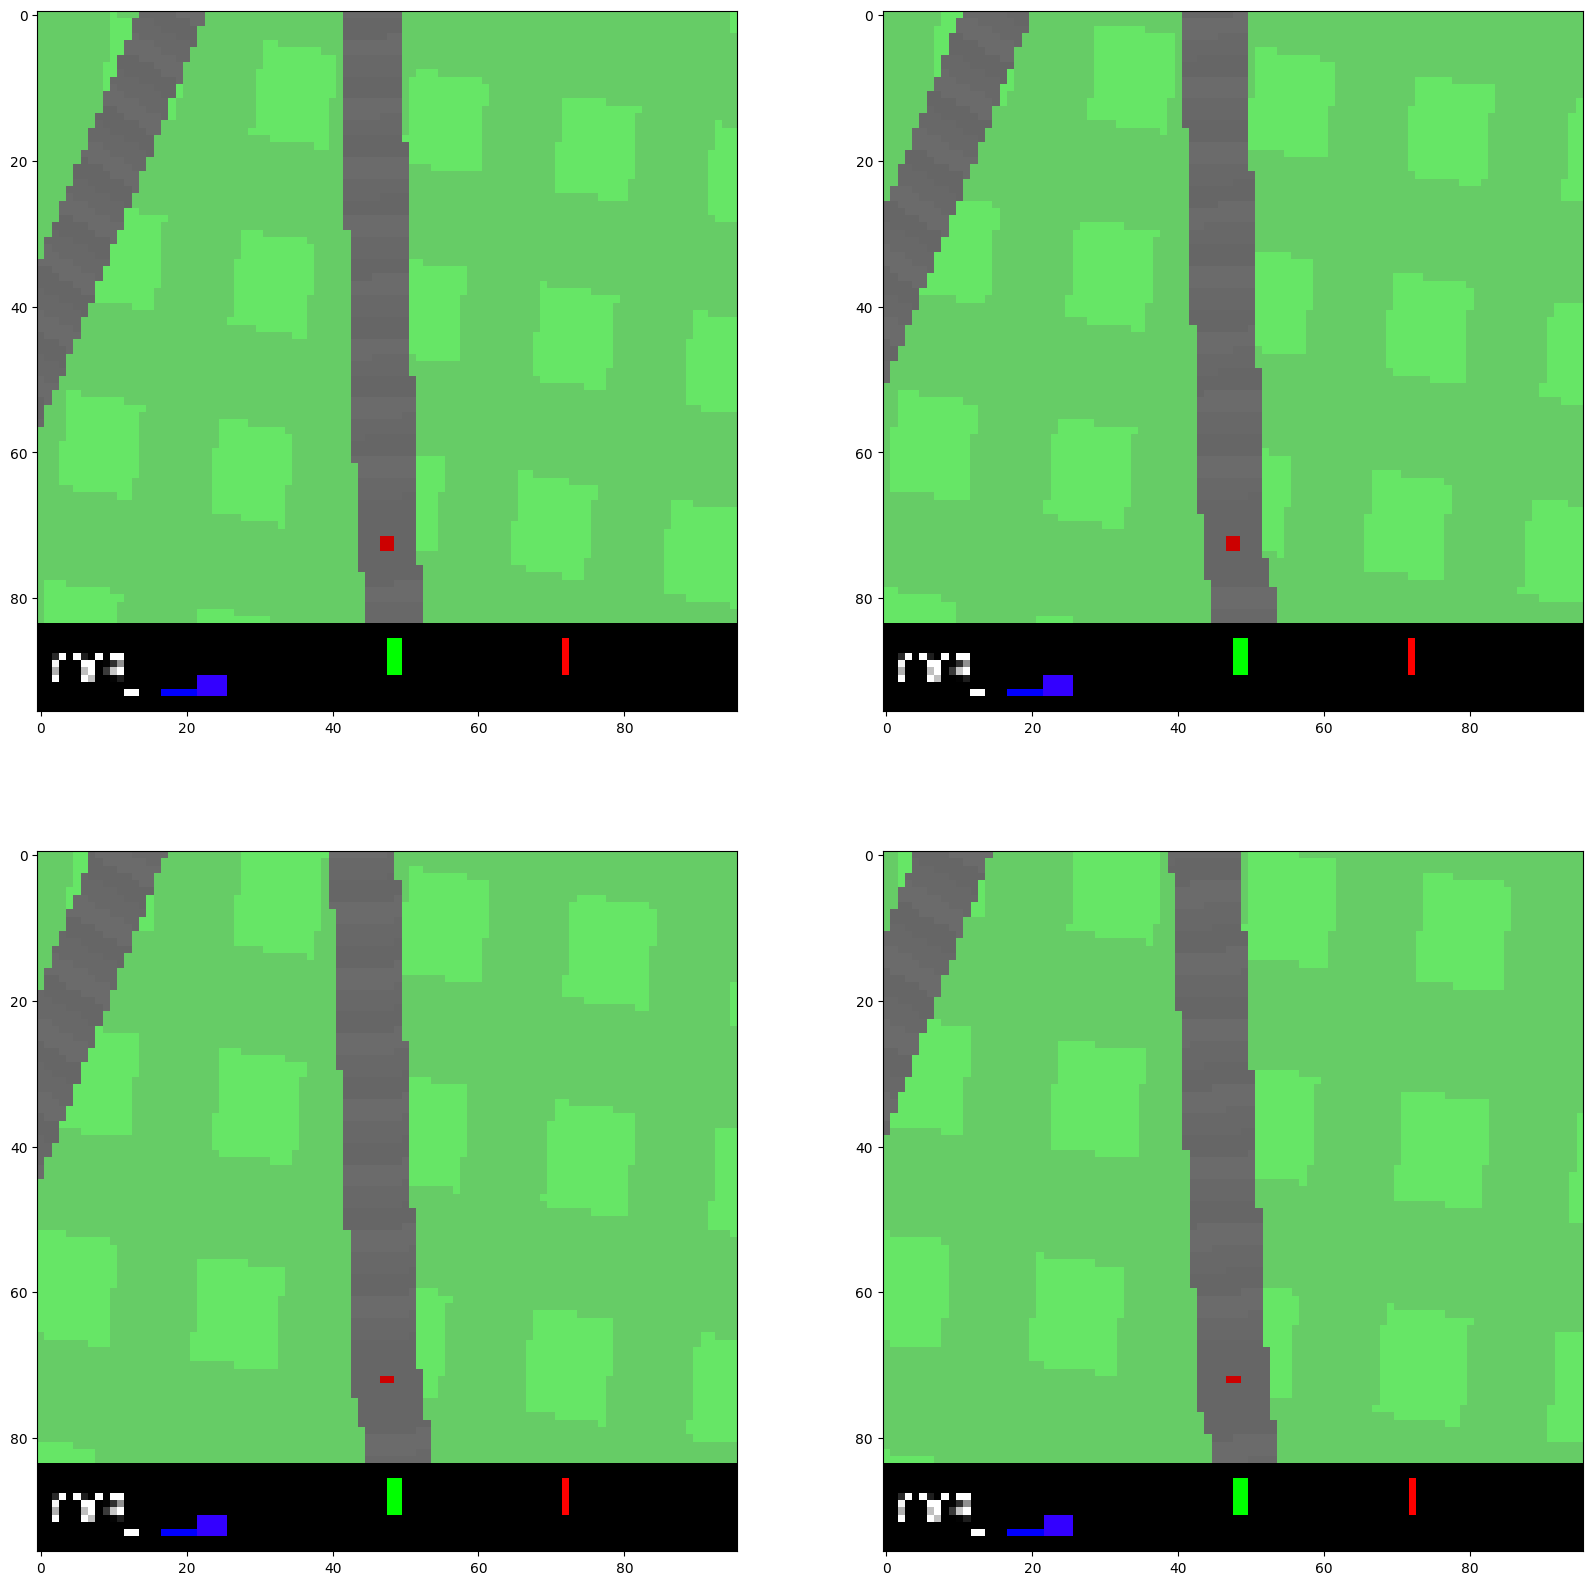

In [9]:
nrows, ncols = 2,2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,20))
batch_idx = 0
for i in range(args.n_frames):
    r = i // nrows
    c = i % ncols
    axs[r][c].imshow(states[0][batch_idx,i,:,:].squeeze(0).permute(1,2,0))

In [10]:
frame_idx = 0 
X_img = states[0].transpose(0,1).to(args.device)
X_sensor = torch.stack(states[1:-1], axis=0).permute(0,2,1).unsqueeze(-1).to(args.device)
X_act = states[-1].transpose(0,1).to(args.device)
actions = actions.unsqueeze(-1).to(args.device)
rewards = rewards.unsqueeze(1).to(args.device)
dones = dones.unsqueeze(1).to(args.device)
X_img.shape, X_sensor.shape, X_act.shape, actions.shape, rewards.shape, dones.shape, X_img[frame_idx].shape, X_sensor[:,frame_idx].shape

(torch.Size([5, 32, 3, 96, 96]),
 torch.Size([7, 5, 32, 1]),
 torch.Size([5, 32]),
 torch.Size([32, 1]),
 torch.Size([32, 1]),
 torch.Size([32, 1]),
 torch.Size([32, 3, 96, 96]),
 torch.Size([7, 32, 1]))

In [11]:
sensor_hs = sensor_net(X_img[frame_idx], X_sensor[:,frame_idx])
X_img_h, X_steering_h, X_speed_h, X_gyro_h, X_abs1_h, X_abs2_h, X_abs3_h, X_abs4_h = sensor_net(X_img[frame_idx], X_sensor[:,frame_idx])

In [12]:
X_img_h.shape, X_steering_h.shape, X_speed_h.shape, X_gyro_h.shape, X_abs1_h.shape, X_abs2_h.shape, X_abs3_h.shape, X_abs4_h.shape

(torch.Size([32, 128]),
 torch.Size([32, 128]),
 torch.Size([32, 128]),
 torch.Size([32, 128]),
 torch.Size([32, 128]),
 torch.Size([32, 128]),
 torch.Size([32, 128]),
 torch.Size([32, 128]))

In [13]:
torch.stack(sensor_hs, axis=0).shape

torch.Size([8, 32, 128])

In [14]:
drive_net = DriveDQN(args)
drive_net.to(args.device)

DriveDQN(
  (sensor_net): SensorModel(
    (cnn): Nature_Paper_Conv_Dropout_Torch(
      (layer1_cnn): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
      (layer2_cnn): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (layer3_cnn): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (layer_4_dense): Linear(in_features=9216, out_features=512, bias=True)
      (out_layer): Linear(in_features=512, out_features=128, bias=True)
    )
    (steering): Linear(in_features=1, out_features=128, bias=True)
    (speed): Linear(in_features=1, out_features=128, bias=True)
    (gyro): Linear(in_features=1, out_features=128, bias=True)
    (abs1): Linear(in_features=1, out_features=128, bias=True)
    (abs2): Linear(in_features=1, out_features=128, bias=True)
    (abs3): Linear(in_features=1, out_features=128, bias=True)
    (abs4): Linear(in_features=1, out_features=128, bias=True)
  )
  (fusion_net): Transformer(
    (encoder): TransformerEn

In [15]:
drive_net(X_img.to(args.device), X_sensor.to(args.device), X_act.to(args.device)).shape

torch.Size([32, 5])

# Testing Agent Setup

In [16]:
environment = env_wrapper.CarRacing(**setup_dict_trans['car racing'])
control = DQN_Agent(environment=environment, **setup_dict_trans['agent'])

In [20]:
control.get_action(state_frame_stack, 0)

1

In [21]:
buffer_ = control.replay_memory 
# populate buffer from above
for i in range(len(buffer.states)):
    buffer_.add_experience(buffer.states[i], buffer.actions[i], 
                           buffer.rewards[i], buffer.dones[i]) 
control.replay_memory_sampler.sampler.num_samples

195

In [22]:
control.experience_replay()

In [23]:
DriveDQN.__name__

'DriveDQN'

In [24]:
sum((p.numel() for p in control.dqn.parameters()))

5573225

In [25]:
sum((p.numel() for p in control.dqn.sensor_net.parameters()))

4862496

In [26]:
sum((p.numel() for p in control.dqn.sensor_net.cnn.parameters()))

4860704

In [32]:
from parameters.drive_net import DriveDQN_simple_fusion_lstm

In [40]:
drive_net_sf = DriveDQN_simple_fusion_lstm(args)

In [42]:
out = drive_net_sf(X_img.to(args.device), X_sensor.to(args.device), X_act.to(args.device))

In [43]:
out.shape

torch.Size([32, 5])

In [182]:
sum((p.numel() for p in drive_net_sf.parameters()))

5573225

In [128]:
h[0][:,args.h_size:].shape

torch.Size([32, 1024])

In [77]:
h[0][:,128:].unsqueeze(1).shape

torch.Size([32, 1, 1024])

In [148]:
cnn_1d_sensor = nn.Conv1d(8, 8, kernel_size=8, stride=4, groups=8)

In [149]:
cnn_1d_sensor(torch.rand(32,8,128)).reshape(32,-1).shape

torch.Size([32, 248])

In [134]:
cnn_1d_sensor.weight.numel()

56

In [122]:
128+255

383

In [135]:
len(h)

5

In [153]:
x = torch.rand(32, 128)
torch.stack([x,x,x,x], axis=1).shape

torch.Size([32, 4, 128])